# Spatial Analysis Mini Project Notebook

In [2]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from shapely.ops import nearest_points
from scipy.spatial import cKDTree
import contextily as cx

In [3]:
# Create an empty list to store a GeoDataFrame for each borough
gdf_list = []

# Iterate through all .shp files in the msoa2021 folder
shapefile_dir = '../data/msoa2021/'
for file in os.listdir(shapefile_dir):
    if file.endswith('.shp'):
        gdf = gpd.read_file(os.path.join(shapefile_dir, file))
        gdf_list.append(gdf)

# Merge into a unified GeoDataFrame
msoa_gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True), crs=gdf_list[0].crs)

# Check
msoa_gdf.head()

msoa21cd       msoa21nm    lad22cd    lad22nm  \
0  E02000813  Southwark 007  E09000028  Southwark   
1  E02000814  Southwark 008  E09000028  Southwark   
2  E02000818  Southwark 012  E09000028  Southwark   
3  E02000823  Southwark 017  E09000028  Southwark   
4  E02000824  Southwark 018  E09000028  Southwark   

                                            geometry  
0  POLYGON ((535370.835 179980.210, 535371.966 17...  
1  POLYGON ((536849.688 180243.484, 536857.165 18...  
2  POLYGON ((533005.562 178966.909, 533012.167 17...  
3  POLYGON ((532234.201 178190.364, 532254.852 17...  
4  POLYGON ((534660.417 178174.228, 534672.991 17...

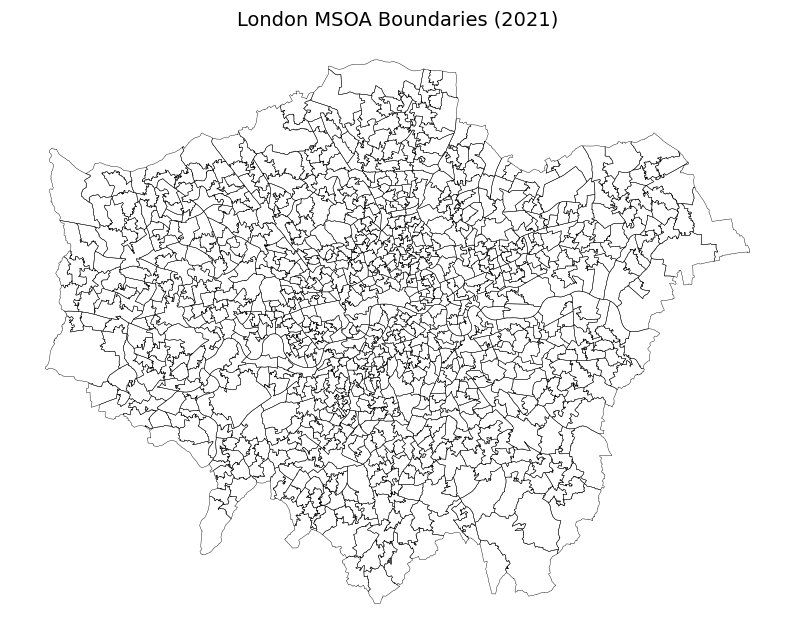

In [4]:
# Visualising London's MSOA areas
fig, ax = plt.subplots(figsize=(10,10))
msoa_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.3)
ax.set_title("London MSOA Boundaries (2021)", fontsize=14)
ax.axis('off')
plt.show()

In [5]:
# Read station data
stations_df = pd.read_csv('../data/StationPoints.csv')
print("Available columns:", stations_df.columns.tolist())
stations_df.head()

Available columns: ['UniqueId', 'StationUniqueId', 'AreaName', 'AreaId', 'Level', 'Lat', 'Lon', 'FriendlyName']


UniqueId StationUniqueId AreaName  AreaId  Level  \
0    910GACTNCTL-1001002-AC-3     910GACTNCTL       AC       3      0   
1   910GACTNCTL-1001002-Bus-1     910GACTNCTL      Bus       1      0   
2  910GACTNCTL-1001002-ENTR-7     910GACTNCTL     ENTR       7      0   
3   910GACTNCTL-1001002-RLY-4     910GACTNCTL      RLY       4      1   
4   910GACTNCTL-1001002-RPL-2     910GACTNCTL      RPL       2      1   

         Lat       Lon FriendlyName  
0  51.508624 -0.263507           AC  
1  51.506514 -0.263717          Bus  
2  51.508925 -0.262602         ENTR  
3  51.508651 -0.262930          RLY  
4  51.508653 -0.263059          RPL

In [6]:
# Create GeoDataFrame (using Lon and Lat)
stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df['Lon'], stations_df['Lat']),
    crs='EPSG:4326'
)

print(f"Station points loaded: {len(stations_gdf)} records")
stations_gdf.head()

Station points loaded: 4064 records


UniqueId StationUniqueId AreaName  AreaId  Level  \
0    910GACTNCTL-1001002-AC-3     910GACTNCTL       AC       3      0   
1   910GACTNCTL-1001002-Bus-1     910GACTNCTL      Bus       1      0   
2  910GACTNCTL-1001002-ENTR-7     910GACTNCTL     ENTR       7      0   
3   910GACTNCTL-1001002-RLY-4     910GACTNCTL      RLY       4      1   
4   910GACTNCTL-1001002-RPL-2     910GACTNCTL      RPL       2      1   

         Lat       Lon FriendlyName                   geometry  
0  51.508624 -0.263507           AC  POINT (-0.26351 51.50862)  
1  51.506514 -0.263717          Bus  POINT (-0.26372 51.50651)  
2  51.508925 -0.262602         ENTR  POINT (-0.26260 51.50892)  
3  51.508651 -0.262930          RLY  POINT (-0.26293 51.50865)  
4  51.508653 -0.263059          RPL  POINT (-0.26306 51.50865)

In [7]:
# Project both MSOA and Station points to British National Grid (EPSG:27700)
msoa_gdf_proj = msoa_gdf.to_crs(epsg=27700)
stations_gdf_proj = stations_gdf.to_crs(epsg=27700)

# Check whether CRS is consistent
print("CRS check:", msoa_gdf_proj.crs == stations_gdf_proj.crs)
msoa_gdf_proj.head()

CRS check: True


msoa21cd       msoa21nm    lad22cd    lad22nm  \
0  E02000813  Southwark 007  E09000028  Southwark   
1  E02000814  Southwark 008  E09000028  Southwark   
2  E02000818  Southwark 012  E09000028  Southwark   
3  E02000823  Southwark 017  E09000028  Southwark   
4  E02000824  Southwark 018  E09000028  Southwark   

                                            geometry  
0  POLYGON ((535370.835 179980.210, 535371.966 17...  
1  POLYGON ((536849.688 180243.484, 536857.165 18...  
2  POLYGON ((533005.562 178966.909, 533012.167 17...  
3  POLYGON ((532234.201 178190.364, 532254.852 17...  
4  POLYGON ((534660.417 178174.228, 534672.991 17...

In [8]:
# Merge all MSOA regions
msoa_union = msoa_gdf_proj.unary_union

# Only keep stations that fall within London
stations_london = stations_gdf_proj[stations_gdf_proj.within(msoa_union)].copy()
print(f"Stations within London: {len(stations_london)} (out of {len(stations_gdf_proj)})")

Stations within London: 3809 (out of 4064)


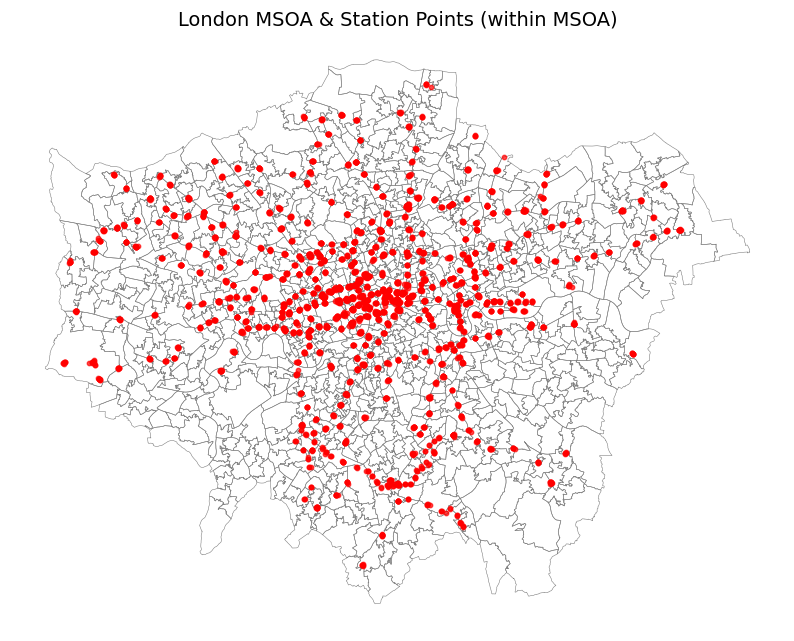

In [9]:
# Visualize MSOA Areas and Projected Station Points
fig, ax = plt.subplots(figsize=(10,10))
msoa_gdf_proj.plot(ax=ax, edgecolor='grey', facecolor='none', linewidth=0.4)
stations_london.plot(ax=ax, markersize=10, color='red', alpha=0.7)
ax.set_title("London MSOA & Station Points (within MSOA)", fontsize=14)
ax.axis('off')
plt.show()

In [10]:
# Read car ownership data
car_df = pd.read_csv('../data/car_ownership_msoa.csv', skiprows=8)
car_df.columns = car_df.columns.str.strip()

# Rename the encoding columns to standard names for easy merge use
car_df.rename(columns={'mnemonic': 'MSOA_code'}, inplace=True)

# Make sure MSOA_code is of type string
car_df['MSOA_code'] = car_df['MSOA_code'].astype(str)

print(f"Car ownership data loaded: {len(car_df)} rows")
car_df.head()

Car ownership data loaded: 4052 rows


2021 super output area - middle layer  MSOA_code Total  \
0              Barking and Dagenham 001  E02000002  2868   
1              Barking and Dagenham 002  E02000003  3929   
2              Barking and Dagenham 003  E02000004  2306   
3              Barking and Dagenham 004  E02000005  3631   
4              Barking and Dagenham 006  E02000007  3671   

  No cars or vans in household  
0                          914  
1                         1156  
2                          545  
3                         1020  
4                         1372

In [11]:
# merge into shapefile
merged_car_df = pd.merge(car_df, msoa_gdf[['msoa21cd', 'lad22nm']], 
                         left_on='MSOA_code', right_on='msoa21cd', how='left')

# Records kept only in the London area
merged_car_df = merged_car_df[merged_car_df['lad22nm'].notna()].copy()

print(f"Filtered car_df to London MSOAs: {len(merged_car_df)} rows")
merged_car_df.head()

Filtered car_df to London MSOAs: 4008 rows


2021 super output area - middle layer  MSOA_code Total  \
0              Barking and Dagenham 001  E02000002  2868   
1              Barking and Dagenham 002  E02000003  3929   
2              Barking and Dagenham 003  E02000004  2306   
3              Barking and Dagenham 004  E02000005  3631   
4              Barking and Dagenham 006  E02000007  3671   

  No cars or vans in household   msoa21cd               lad22nm  
0                          914  E02000002  Barking and Dagenham  
1                         1156  E02000003  Barking and Dagenham  
2                          545  E02000004  Barking and Dagenham  
3                         1020  E02000005  Barking and Dagenham  
4                         1372  E02000007  Barking and Dagenham

In [12]:
# Read household tenure data
tenure_df = pd.read_csv('../data/household_tenure_msoa.csv', skiprows=8)

# Rename the encoding columns
tenure_df.rename(columns={'mnemonic': 'MSOA_code'}, inplace=True)
tenure_df['MSOA_code'] = tenure_df['MSOA_code'].astype(str).str.strip()

print("Sample MSOA codes:")
print(tenure_df['MSOA_code'].head())

print("MSOA prefix counts:")
print(tenure_df['MSOA_code'].str[:3].value_counts())

Sample MSOA codes:
0    E02000002
1    E02000003
2    E02000004
3    E02000005
4    E02000007
Name: MSOA_code, dtype: object
MSOA prefix counts:
MSOA_code
E02    1002
In        1
hav       1
by        1
aff       1
nan       1
Name: count, dtype: int64


In [13]:
# Only records with E02 code are kept
tenure_df = tenure_df[tenure_df['MSOA_code'].str.startswith('E02')].copy()

# Create “Total number of rental homes” and “Total number of owner-owned homes”
tenure_df['Rented_total'] = tenure_df['Rented'] 
tenure_df['Owned_total'] = tenure_df['Owned']

# Create rental rate (rented houses / total number of households)
tenure_df['rent_ratio'] = tenure_df['Rented_total'] / tenure_df['Total']

# Merge to shapefile
merged_tenure_df = pd.merge(tenure_df, msoa_gdf[['msoa21cd', 'lad22nm']], 
                            left_on='MSOA_code', right_on='msoa21cd', how='left')

merged_tenure_df = merged_tenure_df[merged_tenure_df['lad22nm'].notna()].copy()

print(f"Final Tenure data (London only): {len(merged_tenure_df)} rows")
merged_tenure_df.head()

Final Tenure data (London only): 1002 rows


2021 super output area - middle layer  MSOA_code   Total   Owned  \
0              Barking and Dagenham 001  E02000002  2870.0  1243.0   
1              Barking and Dagenham 002  E02000003  3925.0  2206.0   
2              Barking and Dagenham 003  E02000004  2312.0  1562.0   
3              Barking and Dagenham 004  E02000005  3625.0  1928.0   
4              Barking and Dagenham 006  E02000007  3676.0  1515.0   

   Owned: Owns outright  \
0                 506.0   
1                 938.0   
2                 651.0   
3                 578.0   
4                 475.0   

   Owned: Owns with a mortgage or loan or shared ownership  Rented  \
0                                              737.0        1627.0   
1                                             1268.0        1719.0   
2                                              911.0         750.0   
3                                             1350.0        1697.0   
4                                             1040.0        2161.0   

   Rented: Social rented  Rented: Private rented or lives rent free  \
0                 1199.0                                      428.0   
1                  522.0                                     1197.0   
2                  373.0                                      377.0   
3                  912.0                                      785.0   
4                 1552.0                                      609.0   

   Rented_total  Owned_total  rent_ratio   msoa21cd               lad22nm  
0        1627.0       1243.0    0.566899  E02000002  Barking and Dagenham  
1        1719.0       2206.0    0.437962  E02000003  Barking and Dagenham  
2         750.0       1562.0    0.324394  E02000004  Barking and Dagenham  
3        1697.0       1928.0    0.468138  E02000005  Barking and Dagenham  
4        2161.0       1515.0    0.587867  E02000007  Barking and Dagenham

In [14]:
# Convert to numeric value
merged_car_df['No cars or vans in household'] = pd.to_numeric(
    merged_car_df['No cars or vans in household'], errors='coerce'
)

merged_car_df['Total'] = pd.to_numeric(
    merged_car_df['Total'], errors='coerce'
)

# Create a no_car_ratio column
merged_car_df['no_car_ratio'] = merged_car_df['No cars or vans in household'] / merged_car_df['Total']

print("Added no_car_ratio to car ownership data")
merged_car_df[['MSOA_code', 'No cars or vans in household', 'Total', 'no_car_ratio']].head()

Added no_car_ratio to car ownership data


MSOA_code  No cars or vans in household  Total  no_car_ratio
0  E02000002                           914   2868      0.318689
1  E02000003                          1156   3929      0.294222
2  E02000004                           545   2306      0.236340
3  E02000005                          1020   3631      0.280914
4  E02000007                          1372   3671      0.373740

In [15]:
# Distances are calculated using the British National Grid coordinate system (EPSG:27700)
msoa_gdf_proj['centroid'] = msoa_gdf_proj.centroid

In [16]:
# Get the station point coordinates
station_coords = np.array(list(zip(stations_gdf_proj.geometry.x, stations_gdf_proj.geometry.y)))
station_tree = cKDTree(station_coords)

# Get the coordinates of the MSOA center point
msoa_centroids = np.array(list(zip(msoa_gdf_proj['centroid'].x, msoa_gdf_proj['centroid'].y)))

# Query the distance between each MSOA center point and the nearest station (unit: meter)
distances, _ = station_tree.query(msoa_centroids, k=1)

# Add distances to a GeoDataFrame
msoa_gdf_proj['min_distance_to_station'] = distances
distance_df = msoa_gdf_proj[['msoa21cd', 'min_distance_to_station']].copy()

print("Min distance to station calculated for all MSOAs.")
msoa_gdf_proj[['msoa21cd', 'min_distance_to_station']].head()

Min distance to station calculated for all MSOAs.


msoa21cd  min_distance_to_station
0  E02000813               184.337026
1  E02000814               771.418206
2  E02000818               710.596667
3  E02000823               912.368922
4  E02000824               982.419413

In [17]:
# Delete the existing min_distance_to_station and msoa21cd
for col in ['min_distance_to_station', 'msoa21cd']:
    if col in merged_car_df.columns:
        merged_car_df.drop(columns=[col], inplace=True)

# merge distance data
merged_car_df = pd.merge(
    merged_car_df,
    distance_df,
    left_on='MSOA_code',
    right_on='msoa21cd',
    how='left'
)

print("Distance to nearest station merged into analysis dataset.")
merged_car_df[['MSOA_code', 'no_car_ratio', 'min_distance_to_station']].head()

Distance to nearest station merged into analysis dataset.


MSOA_code  no_car_ratio  min_distance_to_station
0  E02000002      0.318689              2320.993808
1  E02000003      0.294222              1067.995867
2  E02000004      0.236340              1457.704739
3  E02000005      0.280914              1183.948537
4  E02000007      0.373740              1649.477318

In [18]:
from scipy.stats import pearsonr

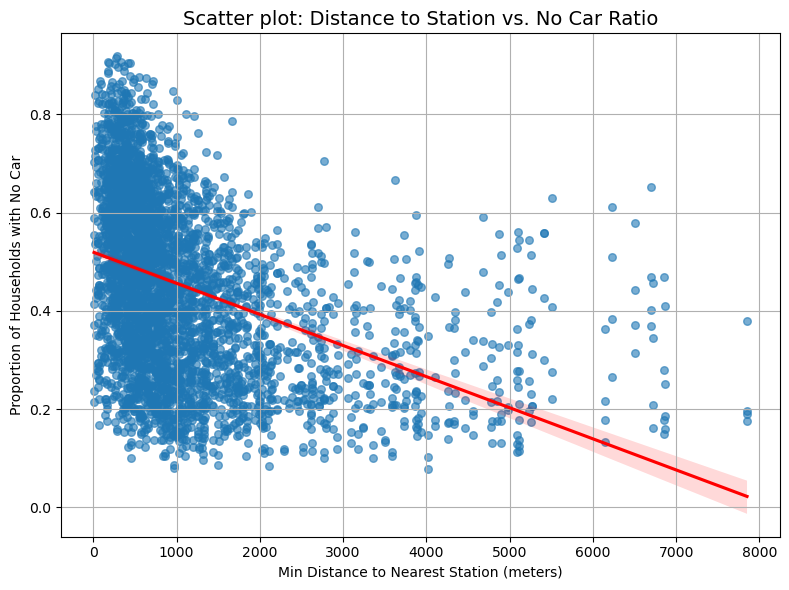

In [19]:
# Create a scatter plot of related variables and a fitted line
plt.figure(figsize=(8,6))
sns.regplot(
    data=merged_car_df,
    x='min_distance_to_station',
    y='no_car_ratio',
    scatter_kws={'alpha': 0.6, 's': 30},
    line_kws={'color': 'red'}
)
plt.title('Scatter plot: Distance to Station vs. No Car Ratio', fontsize=14)
plt.xlabel('Min Distance to Nearest Station (meters)')
plt.ylabel('Proportion of Households with No Car')
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# Calculate Pearson correlation coefficient
corr_coef, p_value = pearsonr(
    merged_car_df['min_distance_to_station'],
    merged_car_df['no_car_ratio']
)

print(f"Pearson correlation: r = {corr_coef:.4f}, p-value = {p_value:.4f}")

Pearson correlation: r = -0.3895, p-value = 0.0000


In [21]:
# Create segmented columns (unit: meter, 500m as a bin)
merged_car_df['distance_bin'] = pd.cut(
    merged_car_df['min_distance_to_station'],
    bins=range(0, int(merged_car_df['min_distance_to_station'].max()) + 500, 500),
    include_lowest=True,
    right=False
)

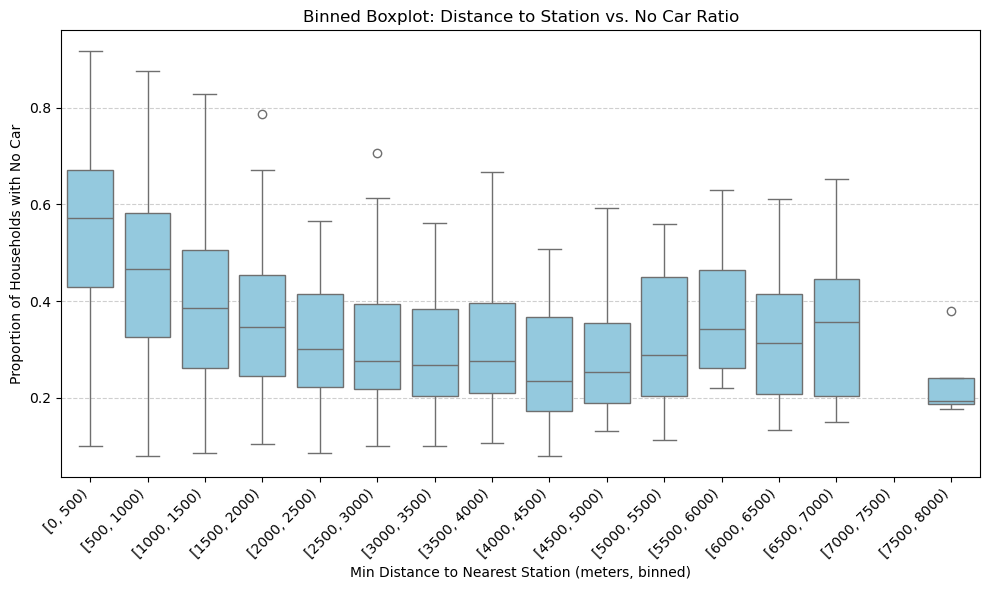

In [22]:
plt.figure(figsize=(10, 6))

# Draw a box plot (x-axis is segment distance, y-axis is the proportion of car-free households)
sns.boxplot(
    data=merged_car_df,
    x='distance_bin',
    y='no_car_ratio',
    color='skyblue'
)

plt.xticks(rotation=45, ha='right')
plt.xlabel('Min Distance to Nearest Station (meters, binned)')
plt.ylabel('Proportion of Households with No Car')
plt.title('Binned Boxplot: Distance to Station vs. No Car Ratio')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [23]:
# Merge no_car_ratio to MSOA shapefile
msoa_map_df = msoa_gdf.merge(
    merged_car_df[['MSOA_code', 'no_car_ratio']],
    left_on='msoa21cd', right_on='MSOA_code',
    how='left'
)

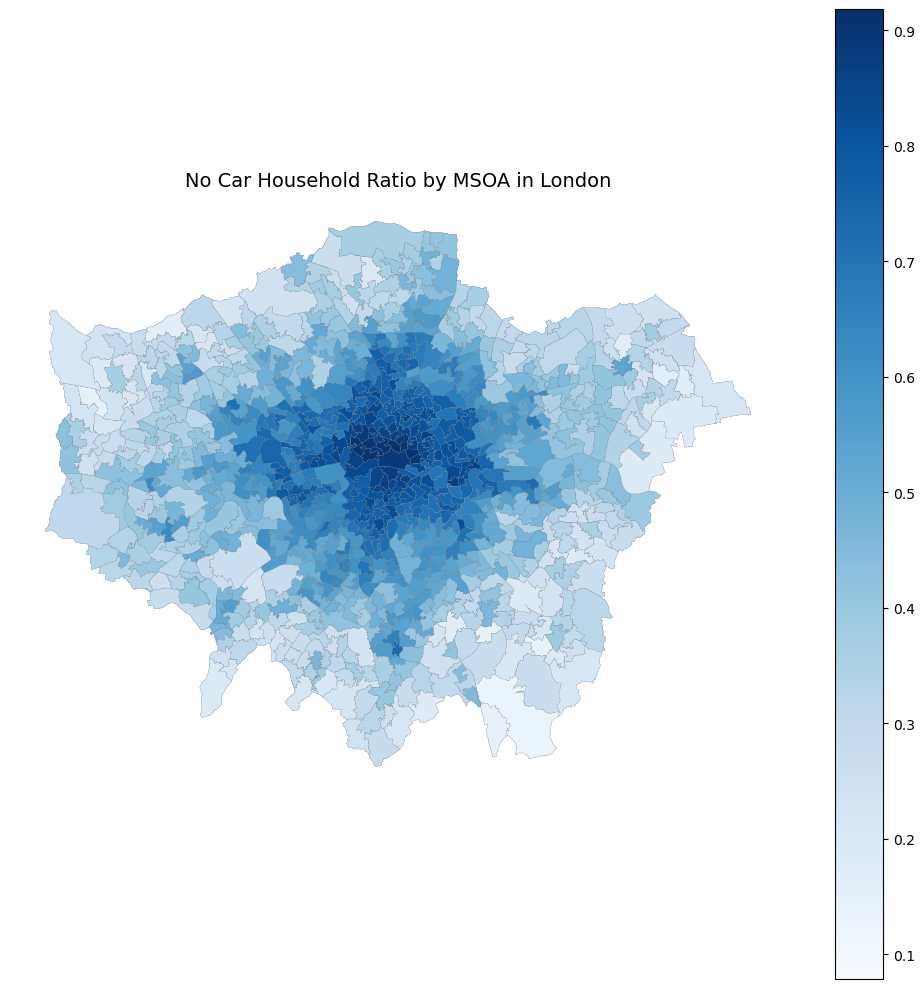

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))

# Visualize the no-car ratio at the MSOA level (no_car_ratio)
msoa_map_df.plot(
    column='no_car_ratio',
    cmap='Blues',
    linewidth=0.1,
    edgecolor='grey',
    legend=True,
    ax=ax
)

ax.set_title("No Car Household Ratio by MSOA in London", fontsize=14)
ax.axis("off")

plt.tight_layout()
plt.show()

In [25]:
msoa_gdf = msoa_gdf.drop(columns=[col for col in ['MSOA_code', 'min_distance_to_station'] if col in msoa_gdf.columns])

# Merge min_diatance_to_station to shapefile
msoa_gdf = pd.merge(
    msoa_gdf,
    merged_car_df[['MSOA_code', 'min_distance_to_station']],
    left_on='msoa21cd',
    right_on='MSOA_code',
    how='left'
)

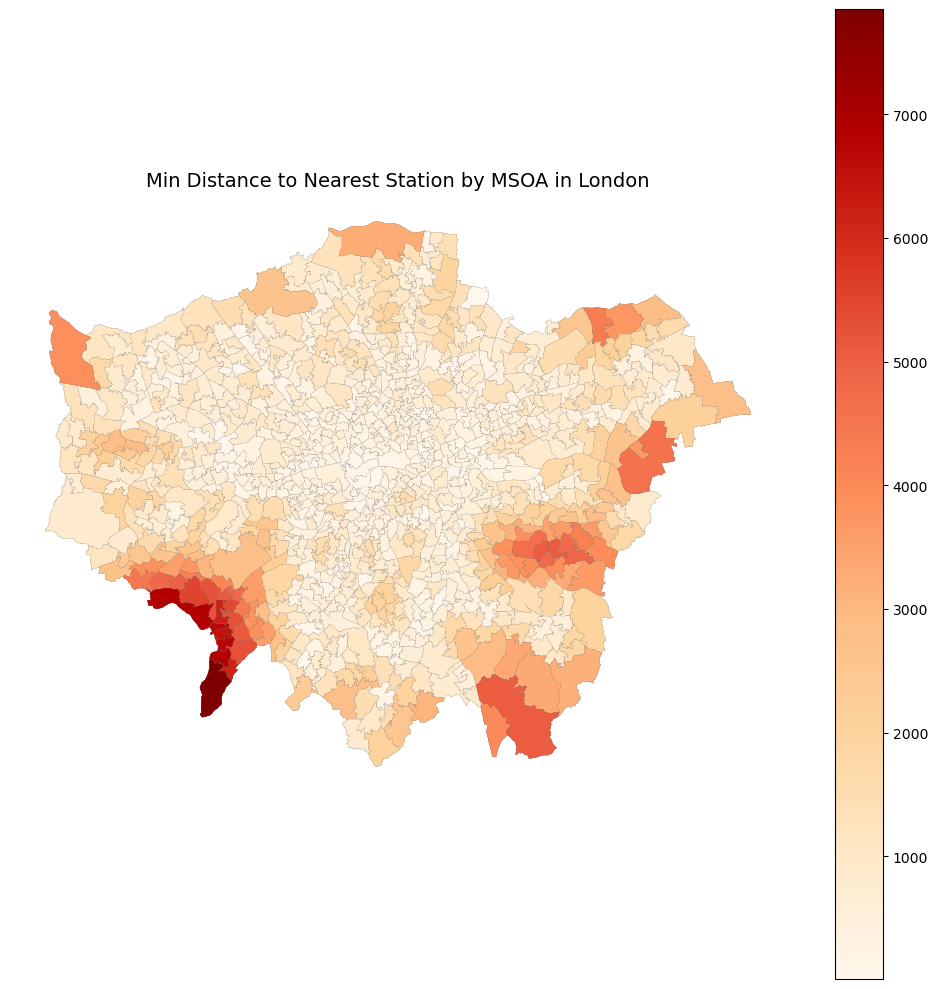

In [26]:
# Create Min Distance to Nearest Station by MSOA
fig, ax = plt.subplots(figsize=(10, 10))
msoa_gdf.plot(
    column='min_distance_to_station',
    cmap='OrRd', 
    linewidth=0.1,
    edgecolor='grey',
    legend=True,
    ax=ax
)

ax.set_title('Min Distance to Nearest Station by MSOA in London', fontsize=14)
ax.axis('off')

plt.tight_layout()
plt.show()

In [72]:
# Extract MSOA regions with legal geometry
msoa_clean = msoa_gdf[
    msoa_gdf['geometry'].notna() &
    (~msoa_gdf.geometry.is_empty) &
    (msoa_gdf.geometry.is_valid)
].copy()
print("Number of valid geometry rows:", len(msoa_clean))

Number of valid geometry rows: 4008


In [73]:
# Merge car + tenure data and ensure MSOA_code is unique
gwr_df = pd.merge(
    merged_car_df[['MSOA_code', 'no_car_ratio', 'min_distance_to_station']],
    merged_tenure_df[['MSOA_code', 'rent_ratio']],
    on='MSOA_code',
    how='inner'
)
print("Number of rows in gwr_df after the merge:", len(gwr_df))
print("Number of unique MSOA_codes:", gwr_df['MSOA_code'].nunique())

Number of rows in gwr_df after the merge: 4008
Number of unique MSOA_codes: 1002


In [74]:
# Deduplication to avoid duplicate geometry merging
gwr_df = gwr_df.drop_duplicates(subset='MSOA_code')

# Merge geometry
gwr_gdf = pd.merge(
    msoa_clean[['msoa21cd', 'geometry']],
    gwr_df,
    left_on='msoa21cd',
    right_on='MSOA_code',
    how='inner'
)

# Creating a GeoDataFrame
gwr_gdf = gpd.GeoDataFrame(gwr_gdf, geometry='geometry', crs=msoa_gdf.crs)
print("Current GWR GeoDataFrame CRS:", gwr_gdf.crs)

Current GWR GeoDataFrame CRS: EPSG:27700


In [77]:
# Extract centroid coordinates
gwr_gdf['X'] = gwr_gdf.geometry.centroid.x
gwr_gdf['Y'] = gwr_gdf.geometry.centroid.y

# Constructing GWR input variables
y = gwr_gdf[['no_car_ratio']].values
X = gwr_gdf[['min_distance_to_station', 'rent_ratio']].values
coords = gwr_gdf[['X', 'Y']].values

# Standardization X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Checking for NaN and Inf Values")
print("X_scaled NaN:", np.isnan(X_scaled).sum(), " | Inf:", np.isinf(X_scaled).sum())
print("y NaN:", np.isnan(y).sum(), " | Inf:", np.isinf(y).sum())
print("coords NaN:", np.isnan(coords).sum(), " | Inf:", np.isinf(coords).sum())

print("X NaN:", gwr_gdf['X'].isna().sum())
print("Y NaN:", gwr_gdf['Y'].isna().sum())
print("Empty geometry:", gwr_gdf.geometry.is_empty.sum())
print("Invalid geometry:", (~gwr_gdf.geometry.is_valid).sum())
print("Total geometry quantity:", len(gwr_gdf))

Checking for NaN and Inf Values
X_scaled NaN: 0  | Inf: 0
y NaN: 0  | Inf: 0
coords NaN: 0  | Inf: 0
X NaN: 0
Y NaN: 0
Empty geometry: 0
Invalid geometry: 0
Total geometry quantity: 4008


In [78]:
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR

In [83]:
# Use AICc as a criterion to select the optimal bandwidth
selector = Sel_BW(coords, y, X_scaled)
opt_bw = selector.search(bw_min=30)

print(f"Optimal bandwidth selected: {opt_bw}")

Optimal bandwidth selected: 33.0


In [84]:
# Fit GWR Model
gwr_model = GWR(coords, y, X_scaled, bw=opt_bw)
gwr_results = gwr_model.fit()

print("GWR model fitting completed")
print("R²:", gwr_results.R2)
print("Adjusted R²:", gwr_results.adj_R2)

GWR model fitting completed
R²: 0.9943916111674135
Adjusted R²: 0.9932851446857333


In [86]:
# Each column is the spatial regression coefficient of a variable (including intercept)
gwr_gdf['intercept'] = gwr_results.params[:, 0]
gwr_gdf['b_min_dist'] = gwr_results.params[:, 1]
gwr_gdf['b_rent_ratio'] = gwr_results.params[:, 2]

# Preserve Local R²
gwr_gdf['local_R2'] = gwr_results.localR2

In [87]:
# Select a few variables to check the distribution
print(gwr_gdf[['b_min_dist', 'b_rent_ratio', 'local_R2']].describe())

        b_min_dist  b_rent_ratio     local_R2
count  4008.000000   4008.000000  4008.000000
mean     -0.037721      0.101319     0.919755
std       0.099429      0.062209     0.136076
min      -0.624708     -0.210092    -1.606872
25%      -0.069018      0.077329     0.906130
50%      -0.021799      0.101902     0.954845
75%       0.003729      0.126584     0.981753
max       0.817952      0.765657     0.999888


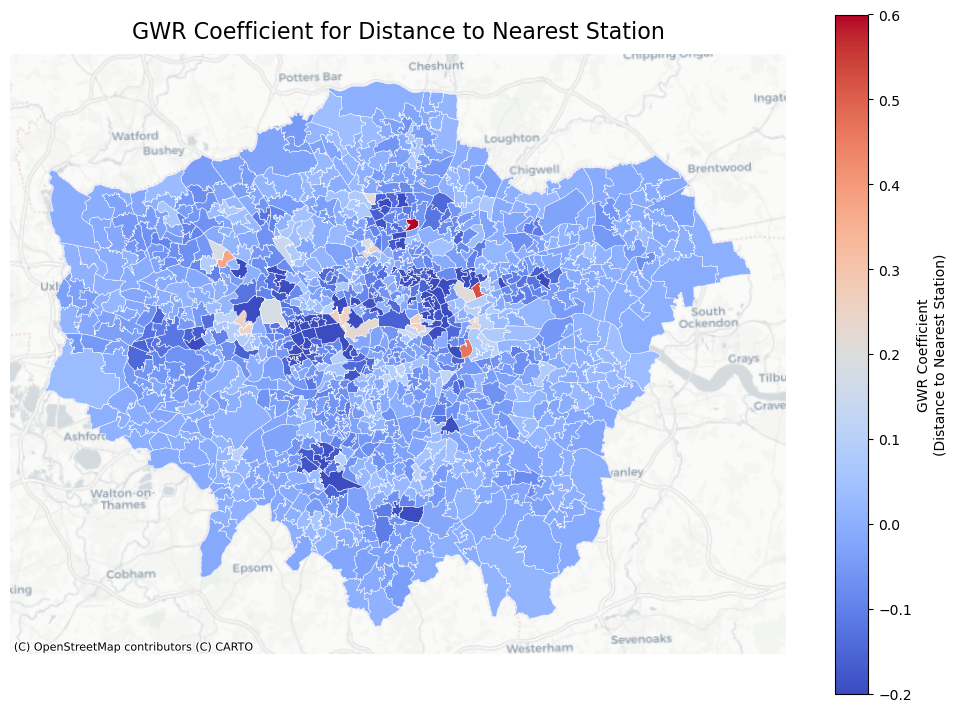

In [93]:
# Visualize the distribution of regression coefficients for min_distance_to_station
fig, ax = plt.subplots(figsize=(10, 10))

# Plot GWR coefficient with improved design
gwr_gdf.plot(
    column='b_min_dist',
    cmap='coolwarm', 
    linewidth=0.3,
    edgecolor='white',
    legend=True,
    legend_kwds={
        'label': "GWR Coefficient\n(Distance to Nearest Station)",
        'shrink': 0.7,
        'orientation': 'vertical'
    },
    ax=ax,
    vmin=-0.2, 
    vmax=0.6
)

# Title and style
ax.set_title("GWR Coefficient for Distance to Nearest Station", fontsize=16, pad=12)
ax.axis('off')

# Add basemap
cx.add_basemap(ax, crs=gwr_gdf.crs, source=cx.providers.CartoDB.Positron)

plt.tight_layout()
plt.show()

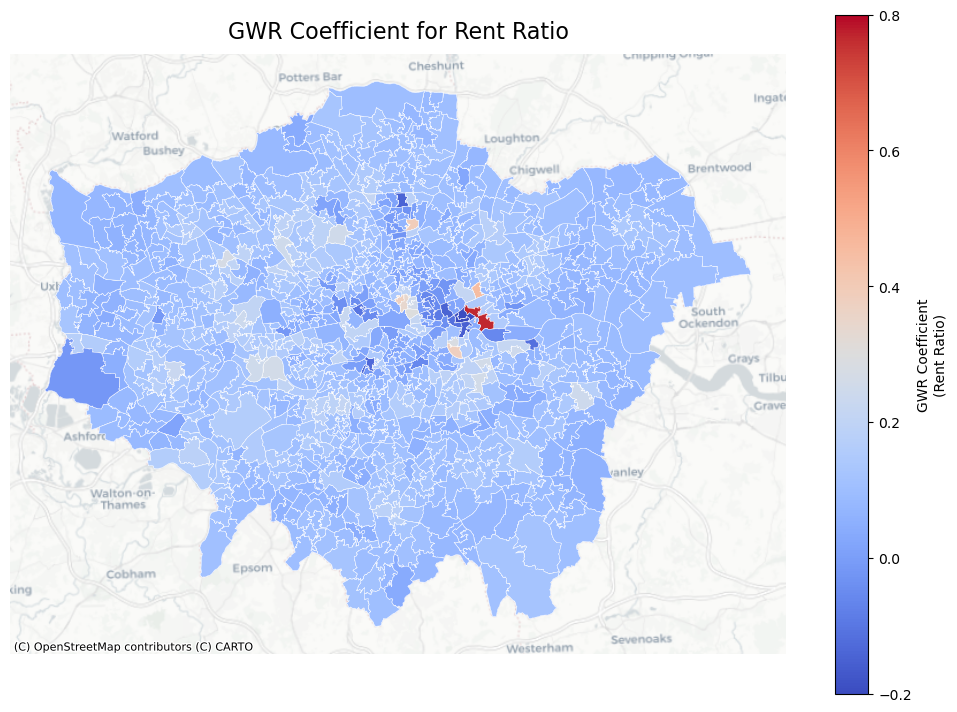

In [101]:
# Visualize the regression coefficient distribution of rent_ratio
fig, ax = plt.subplots(figsize=(10, 10))

gwr_gdf.plot(
    column='b_rent_ratio',
    cmap='coolwarm',
    linewidth=0.3,
    edgecolor='white',
    legend=True,
    legend_kwds={
        'label': "GWR Coefficient\n(Rent Ratio)",
        'shrink': 0.7,
        'orientation': 'vertical'
    },
    ax=ax,
    vmin=-0.2, 
    vmax=0.8
)

ax.set_title("GWR Coefficient for Rent Ratio", fontsize=16, pad=12)
ax.axis('off')
cx.add_basemap(ax, crs=gwr_gdf.crs, source=cx.providers.CartoDB.Positron)
plt.tight_layout()
plt.show()

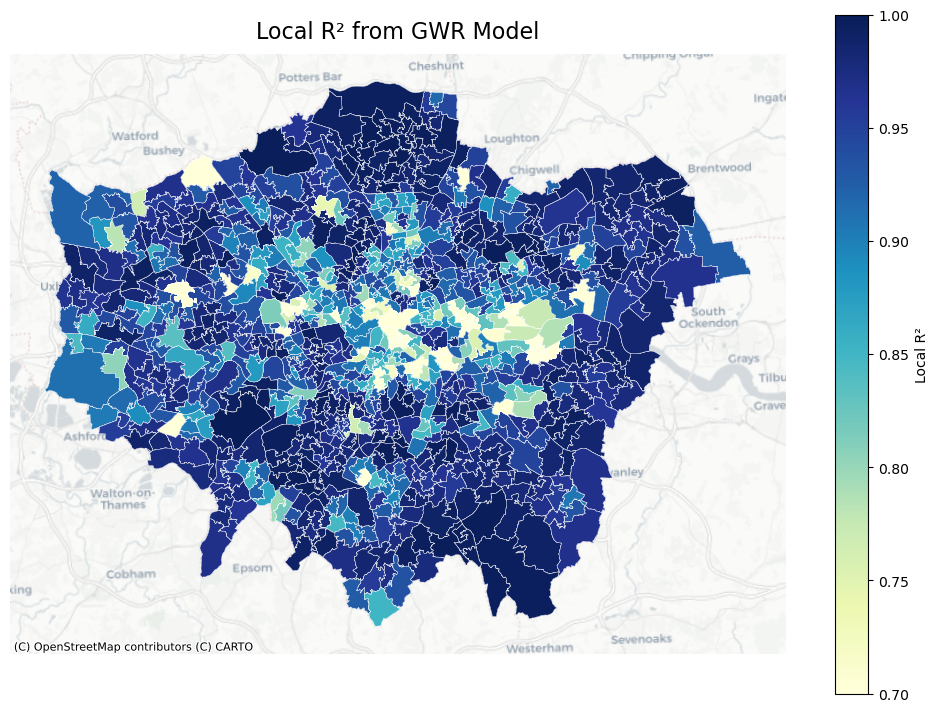

In [102]:
# Visualizing the local R² distribution
fig, ax = plt.subplots(figsize=(10, 10))

gwr_gdf.plot(
    column='local_R2',
    cmap='YlGnBu',
    linewidth=0.3,
    edgecolor='white',
    legend=True,
    legend_kwds={
        'label': "Local R²",
        'shrink': 0.7,
        'orientation': 'vertical'
    },
    ax=ax,
    vmin=0.7, 
    vmax=1.0
)

ax.set_title("Local R² from GWR Model", fontsize=16, pad=12)
ax.axis('off')
cx.add_basemap(ax, crs=gwr_gdf.crs, source=cx.providers.CartoDB.Positron)
plt.tight_layout()
plt.show()

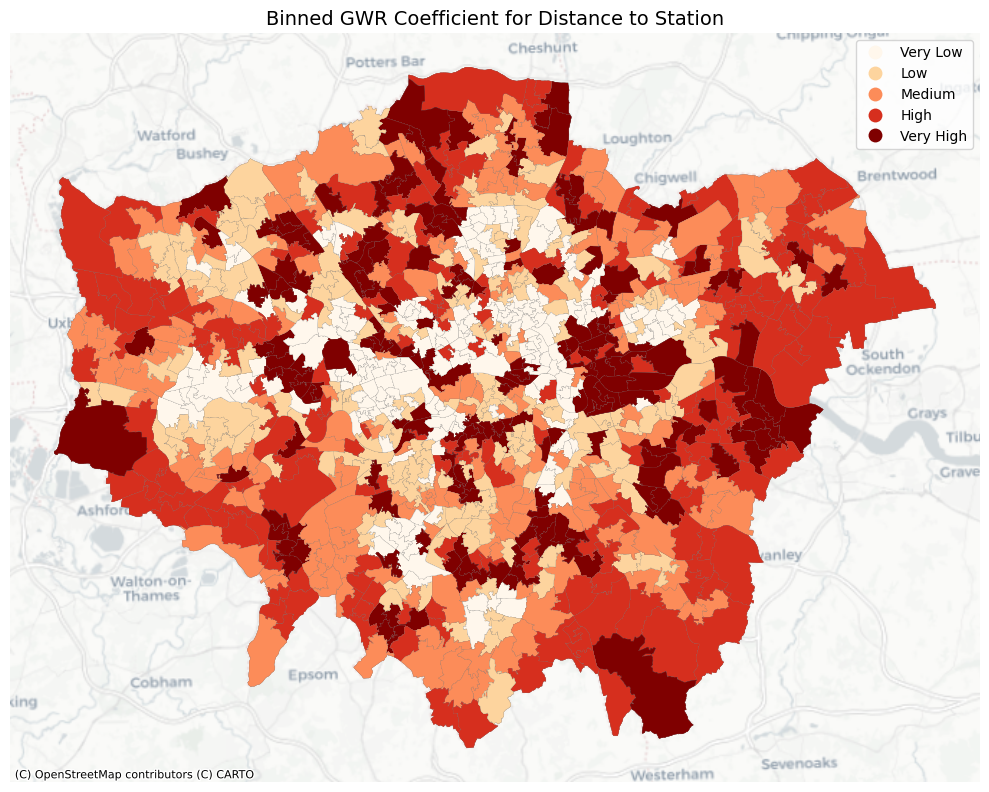

In [105]:
# Binning b_min_dist
gwr_gdf['b_min_dist_bin'] = pd.qcut(gwr_gdf['b_min_dist'], q=5, labels=["Very Low", "Low", "Medium", "High", "Very High"])

fig, ax = plt.subplots(figsize=(10, 10))
gwr_gdf.plot(
    column='b_min_dist_bin',
    categorical=True,
    cmap='OrRd',
    legend=True,
    linewidth=0.1,
    edgecolor='grey',
    ax=ax
)

ax.set_title("Binned GWR Coefficient for Distance to Station", fontsize=14)
ax.axis('off')
cx.add_basemap(ax, crs=gwr_gdf.crs, source=cx.providers.CartoDB.Positron)
plt.tight_layout()
plt.show()

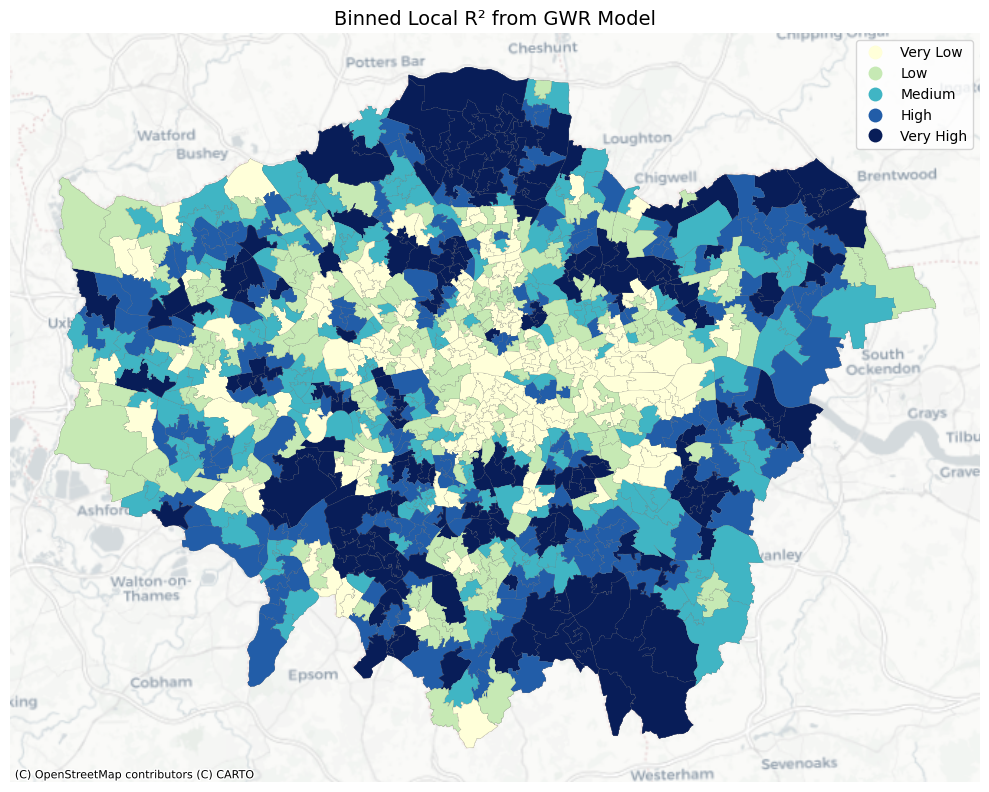

In [106]:
# Bin local_R2
gwr_gdf['local_R2_bin'] = pd.qcut(gwr_gdf['local_R2'], q=5, labels=["Very Low", "Low", "Medium", "High", "Very High"])

fig, ax = plt.subplots(figsize=(10, 10))
gwr_gdf.plot(
    column='local_R2_bin',
    categorical=True,
    cmap='YlGnBu',
    legend=True,
    linewidth=0.1,
    edgecolor='grey',
    ax=ax
)

ax.set_title("Binned Local R² from GWR Model", fontsize=14)
ax.axis('off')
cx.add_basemap(ax, crs=gwr_gdf.crs, source=cx.providers.CartoDB.Positron)
plt.tight_layout()
plt.show()

In [107]:
import statsmodels.api as sm

In [112]:
# OLS compared with GWR
# Constructing independent variable constant term and dependent variable
X_ols = gwr_gdf[['min_distance_to_station', 'rent_ratio']]
X_ols = sm.add_constant(X_ols) 
y_ols = gwr_gdf['no_car_ratio']

# Fitting the OLS Model
ols_model = sm.OLS(y_ols, X_ols).fit()

# Output fit index
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:           no_car_ratio   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                 1.021e+04
Date:                Thu, 17 Apr 2025   Prob (F-statistic):               0.00
Time:                        00:46:04   Log-Likelihood:                 4855.5
No. Observations:                4008   AIC:                            -9705.
Df Residuals:                    4005   BIC:                            -9686.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

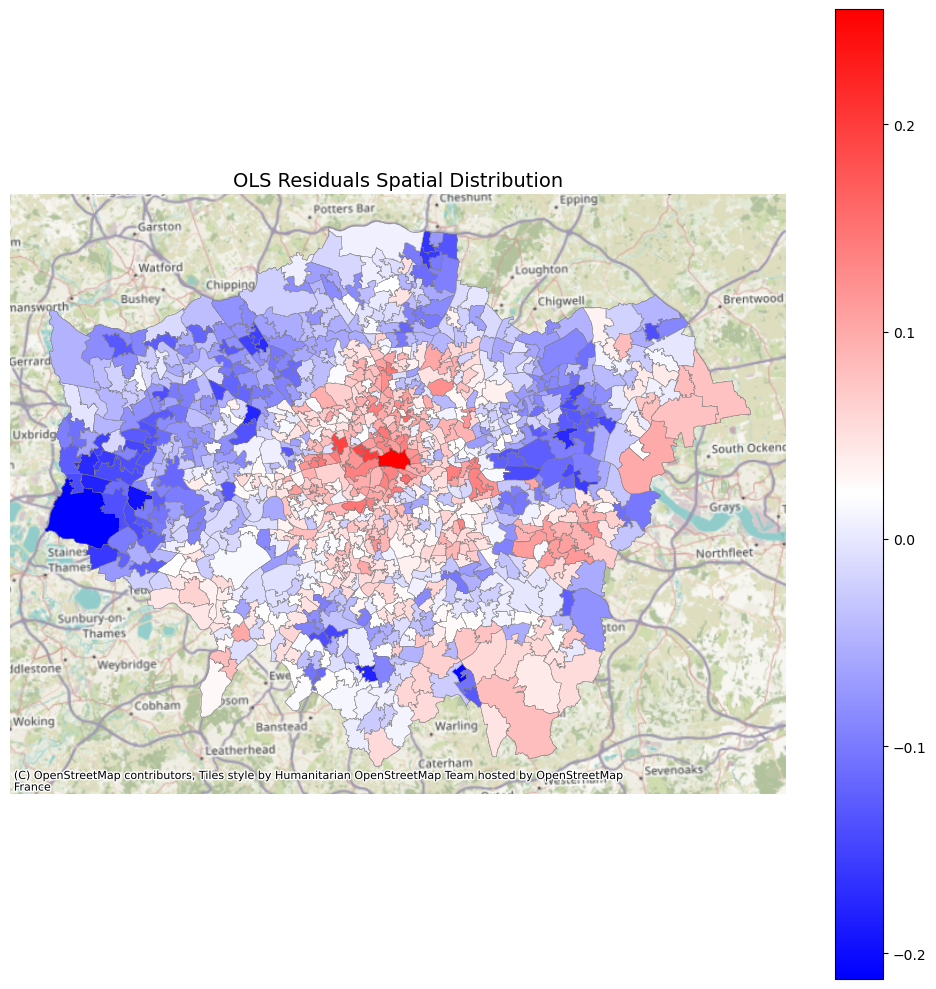

In [114]:
# Get residuals
gwr_gdf['ols_resid'] = ols_model.resid

# Visualizing the spatial distribution of residuals
fig, ax = plt.subplots(figsize=(10, 10))
gwr_gdf.plot(
    column='ols_resid',
    cmap='bwr',
    legend=True,
    edgecolor='grey',
    linewidth=0.3,
    ax=ax
)
ax.set_title("OLS Residuals Spatial Distribution", fontsize=14)
ax.axis('off')
cx.add_basemap(ax, crs=gwr_gdf.crs)
plt.tight_layout()
plt.show()

In [115]:
import libpysal
from esda.moran import Moran
from splot.esda import moran_scatterplot

/var/folders/dl/kdk6kjfj2p5fbtpmhk4629440000gn/T/ipykernel_1169/2718210650.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(gwr_gdf)


Moran's I: 0.6759878421109407
p-value: 0.001


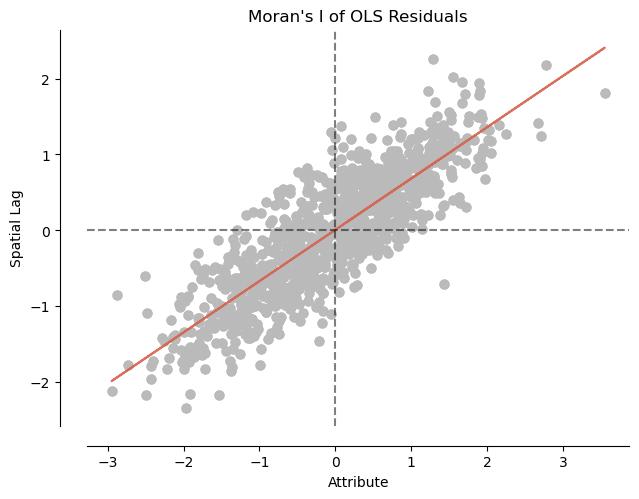

In [117]:
# Constructing the spatial weight matrix
w = libpysal.weights.Queen.from_dataframe(gwr_gdf)
w.transform = 'r'

# Calculating Moran's I
moran_resid = Moran(gwr_gdf['ols_resid'], w)

print("Moran's I:", moran_resid.I)
print("p-value:", moran_resid.p_sim)

# Moran scatterplot
fig, ax = moran_scatterplot(moran_resid)
ax.set_title("Moran's I of OLS Residuals")
plt.show()